In [1]:
############################################################
# Implementation of the cal_example_zerox.m
# Used to verify the code base works without errors.
############################################################

import numpy as np
import matplotlib.pyplot as plt
import arviz

from mcmc.mcmc import MCMC
from mcmc.data import Data
# from mcmc.chain import Chain
from mcmc.parameter import Parameter

from mcmc.models.kennedyohagan.model1 import Model

# Setup Model

In [2]:
#################
##### MODEL #####
#################

model = Model(
    params={
        'theta': Parameter(
            'theta',
            np.array([0.4]),
            bounded_below=0,
            bounded_above=1,
        ),
        'omega_eta': Parameter(
            'omega_eta',
            np.array([
                np.exp(-50/4), 
                np.exp(-7/4)
            ]),
            bounded_below=0,
            bounded_above=1,
        ),
        'omega_delta': Parameter(
            'omega_delta',
            np.array([
                np.exp(-2/4)
            ]),
            bounded_below=0,
            bounded_above=1,
        ),
        'lambda_eta': Parameter(
            'lambda_eta',
            np.array([1]),
            positive=True,
        ),
        'lambda_delta': Parameter(
            'lambda_delta',
            np.array([30]),
            positive=True,
        ),
        'lambda_epsilon': Parameter(
            'lambda_epsilon',
            np.array([1000]),
            positive=True,
        ),
        'lambda_epsilon_eta': Parameter(
            'lambda_epsilon_eta',
            np.array([10000]),
            positive=True,
        )
    }
)

# Setup Data

In [3]:

################
##### DATA #####
################

DATAFIELD = np.loadtxt('data/simple_field.csv', delimiter=',', dtype=np.float32)
DATACOMP = np.loadtxt('data/simple_comp.csv', delimiter=',', dtype=np.float32)

xf = np.reshape(DATAFIELD[:, 0], (-1, 1))
xc = np.reshape(DATACOMP[:, 0], (-1,1))
tc = np.reshape(DATACOMP[:, 1], (-1,1))
yf = np.reshape(DATAFIELD[:, 1], (-1,1))
yc = np.reshape(DATACOMP[:, 2], (-1,1))



#Standardize full response using mean and std of yc
yc_mean = np.mean(yc)
yc_std = np.std(yc)
x_min = min(xf.min(), xc.min())
x_max = max(xf.max(), xc.max())
t_min = tc.min()
t_max = tc.max()

xf_normalized = (xf - x_min)/(x_max - x_min)
xc_normalized = (xc - x_min)/(x_max - x_min)
# tc_normalized = np.zeros_like(tc)
# for k in range(tc.shape[1]):
#     tc_normalized[:, k] = (tc[:, k] - np.min(tc[:, k]))/(np.max(tc[:, k]) - np.min(tc[:, k]))
tc_normalized = (tc - t_min)/(t_max - t_min)
yc_standardized = (yc - yc_mean)/yc_std
yf_standardized = (yf - yc_mean)/yc_std

data = Data(
    x_c = xc_normalized, 
    t   = tc_normalized,
    y   = yc_standardized,
    x_f = xf_normalized,
    z   = yf_standardized
)

# Run MCMC

In [4]:
################
##### MCMC #####
################

proposal_widths = {
    'theta': [0.25],
    'omega_eta': [0.000001, 0.3],
    'omega_delta': [0.7],
    'lambda_eta': 0.15,
    'lambda_epsilon_eta': 10000,
    'lambda_delta': 40,
    'lambda_epsilon': 5000
}

mcmc = MCMC(
    max_iter = 5000,
    model = model,
    data = data,
    proposal_widths = proposal_widths
)

mcmc.run()

['theta_0', 'omega_eta_0', 'omega_eta_1', 'omega_delta_0', 'lambda_eta_0', 'lambda_delta_0', 'lambda_epsilon_0', 'lambda_epsilon_eta_0']
Iteration: 0. Log-Posterior: 878.7903349761241
{'theta_0': 0.4, 'omega_eta_0': 3.7266532e-06, 'omega_eta_1': 0.17377394, 'omega_delta_0': 0.60653067, 'lambda_eta_0': 1.0, 'lambda_delta_0': 30.0, 'lambda_epsilon_0': 1000.0, 'lambda_epsilon_eta_0': 10000.0}
Iteration: 50. Log-Posterior: 1031.2030739544284
{'theta_0': 0.56007046, 'omega_eta_0': 6.4919936e-07, 'omega_eta_1': 0.42491168, 'omega_delta_0': 0.94146395, 'lambda_eta_0': 0.35975137, 'lambda_delta_0': 35.42399, 'lambda_epsilon_0': 9989.639, 'lambda_epsilon_eta_0': 51333.527}
Iteration: 100. Log-Posterior: 1031.1200815136624
{'theta_0': 0.60752964, 'omega_eta_0': 4.021462e-06, 'omega_eta_1': 0.3563179, 'omega_delta_0': 0.4332362, 'lambda_eta_0': 0.25456974, 'lambda_delta_0': 41.552166, 'lambda_epsilon_0': 4588.9536, 'lambda_epsilon_eta_0': 65388.59}
Iteration: 150. Log-Posterior: 1031.955276629121

# Analysis

In [5]:
####################
##### ANALYSIS #####
####################

mcmc.chain._chain['theta_0'] = mcmc.chain._chain['theta_0']*(t_max - t_min) + t_min
output = mcmc.chain._chain
for item, value in output.items():
    print(item, np.mean(value), np.min(value), np.max(value))


arviz.summary(mcmc.chain._chain)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


theta_0 0.42575034110936383 0.36886546035398027 0.4708541665244823
omega_eta_0 3.822615490747694e-06 1.4485647170658922e-07 1.2949158190167509e-05
omega_eta_1 0.40990878418684007 0.24877062439918518 0.5524482727050781
omega_delta_0 0.6893629606743227 0.00039404042763635516 0.999640166759491
lambda_eta_0 0.2443418035313487 0.09942219406366348 0.9509084820747375
lambda_delta_0 37.05075374031067 11.726982116699219 78.569580078125
lambda_epsilon_0 10001.871200292968 2376.608154296875 22422.482421875
lambda_epsilon_eta_0 79059.3803595703 10007.7119140625 117401.734375


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,0.426,0.013,0.403,0.450,0.000,0.000,1457.0,1321.0,NaN
omega_eta_0,0.000,0.000,0.000,0.000,0.000,0.000,15.0,21.0,NaN
omega_eta_1,0.410,0.043,0.333,0.490,0.005,0.004,68.0,360.0,NaN
omega_delta_0,0.689,0.296,0.118,1.000,0.021,0.015,134.0,79.0,NaN
lambda_eta_0,0.244,0.063,0.149,0.348,0.007,0.005,83.0,251.0,NaN
lambda_delta_0,37.051,9.508,21.643,57.079,0.345,0.251,802.0,966.0,NaN
lambda_epsilon_0,10001.871,3113.286,4702.331,15957.481,238.121,171.250,186.0,380.0,NaN
lambda_epsilon_eta_0,79059.380,10040.900,62927.680,97021.188,988.806,701.179,123.0,153.0,NaN


In [6]:
plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

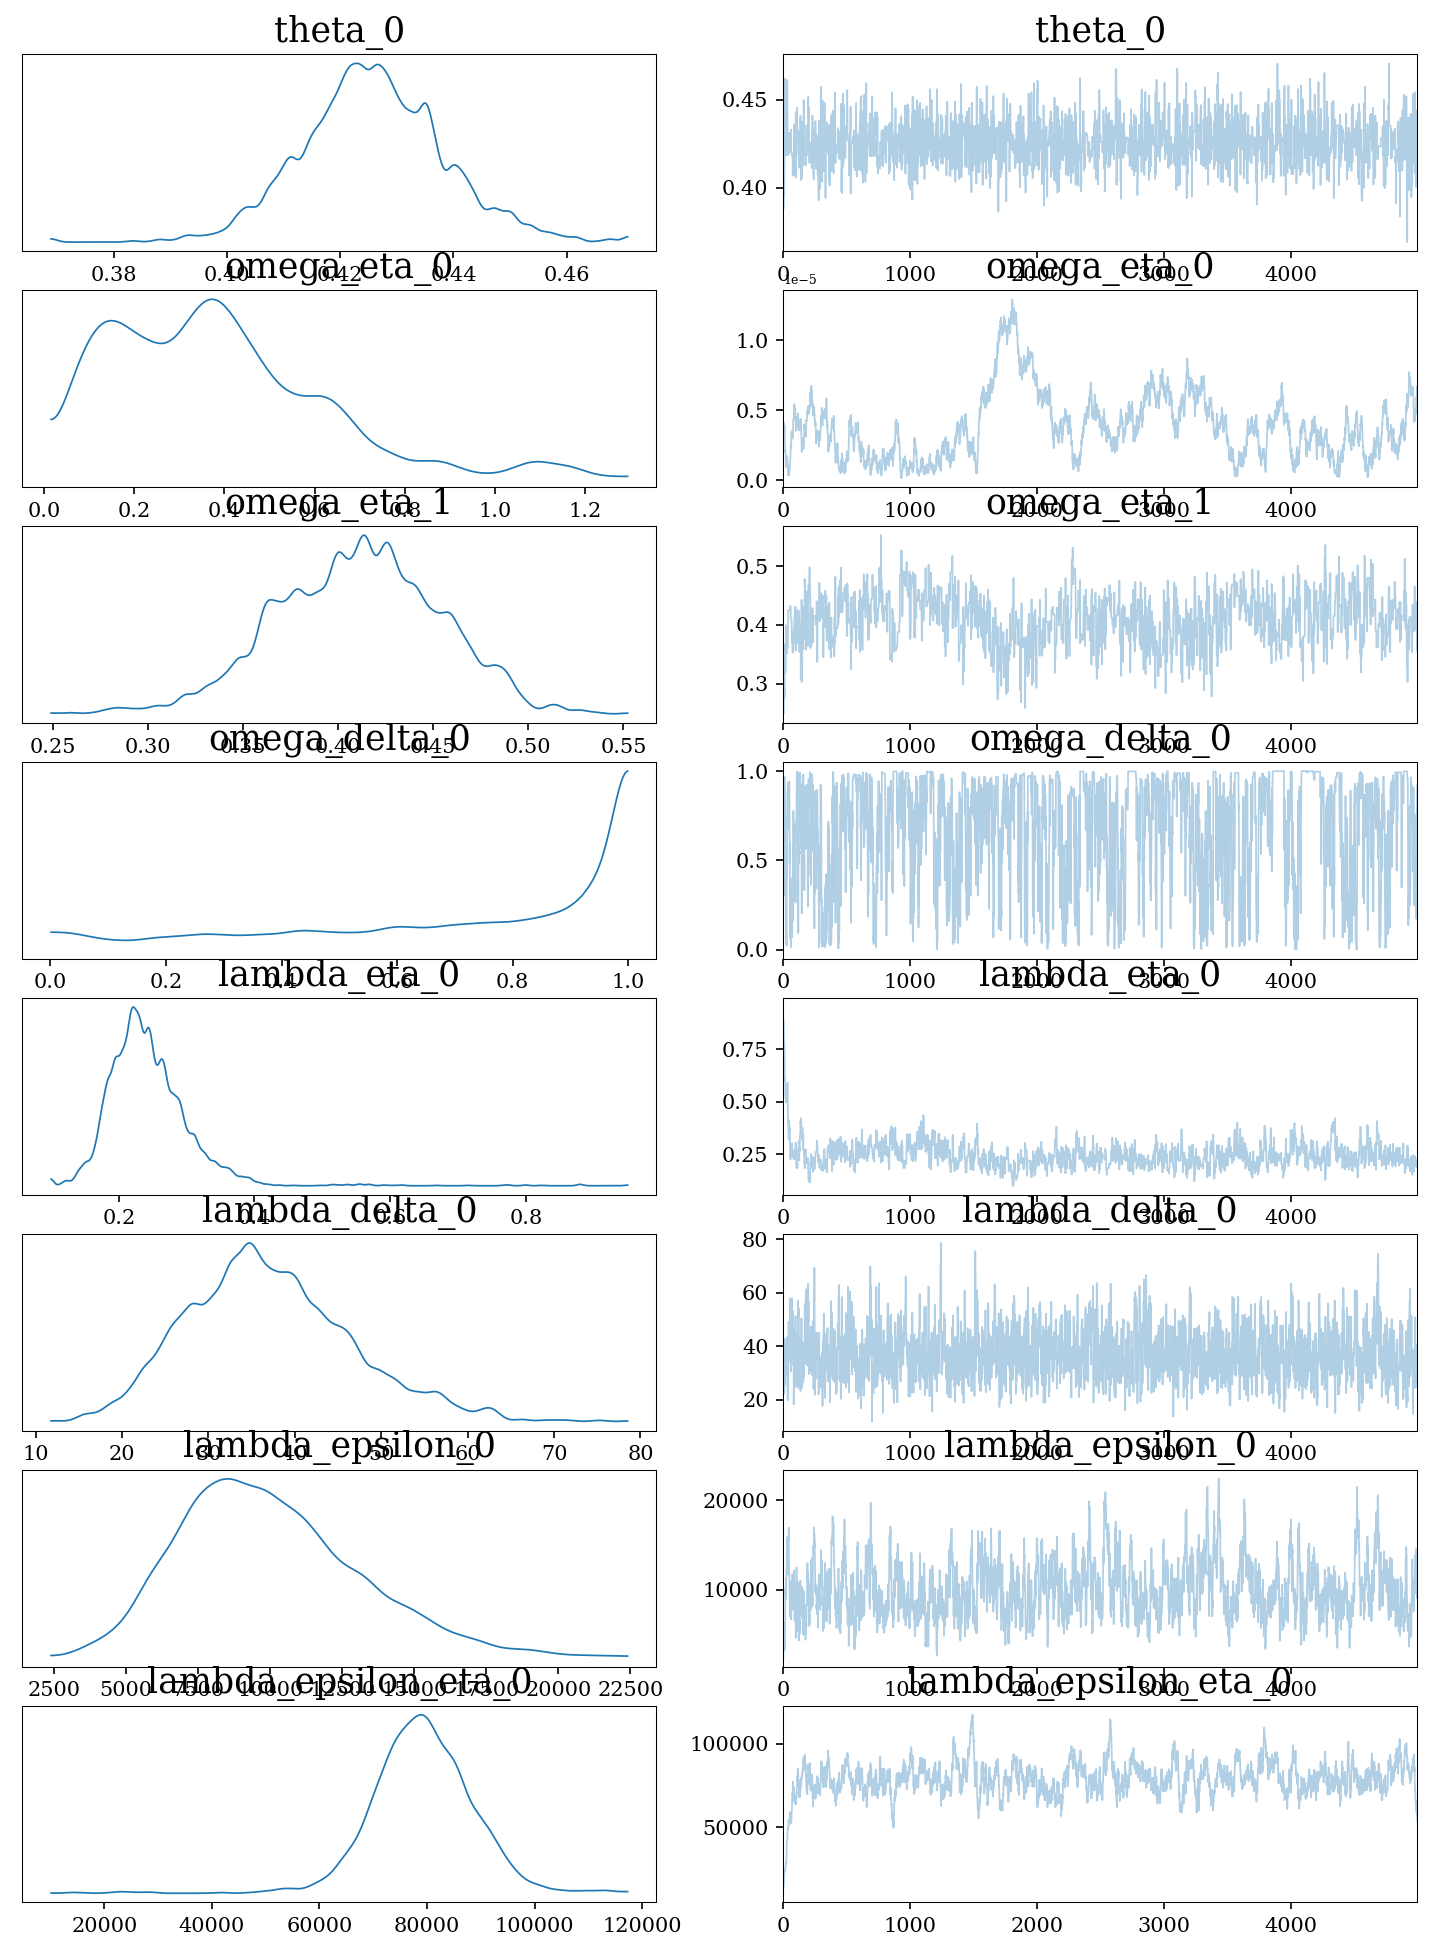

In [7]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        mcmc.chain._chain
    )